In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")

# Загрузка и предобработка данных + подготовка дашборда

In [3]:
prices = pd.read_csv("factors/usa/close_price.csv", index_col=0, parse_dates=True)
prices = prices.replace(0, np.nan)
prices = prices.iloc[:-1]

In [4]:
universe = prices > 10

benchmark = pqr.universe_as_benchmark(
    prices=prices,
    universe=universe,
)

In [5]:
table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)
chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.utils.partial(
            pqr.metrics.compounded_returns,
            log_scale=True
        )
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

summary = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[table, chart]
)

In [6]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.filter, universe=universe),
    pqr.utils.partial(pqr.look_back_pct_change, period=12),
    pqr.utils.partial(pqr.hold, period=12)
)
mom = dynamic_transform(prices)

# Строим time-series факторную модель

,Winners,Losers
"Monthly Mean Return, %",0.75*** (4.12),0.69*** (2.92)
"Monthly Volatility, %",4.35,5.67
"Maximum Drawdown, %",-50.01,-47.67
Sharpe Ratio,0.60,0.42
"Mean Excess Return, %",-0.27,-0.97
"Alpha, %",1.03 (1.65),-1.37 (-1.06)
Beta,0.86,1.04


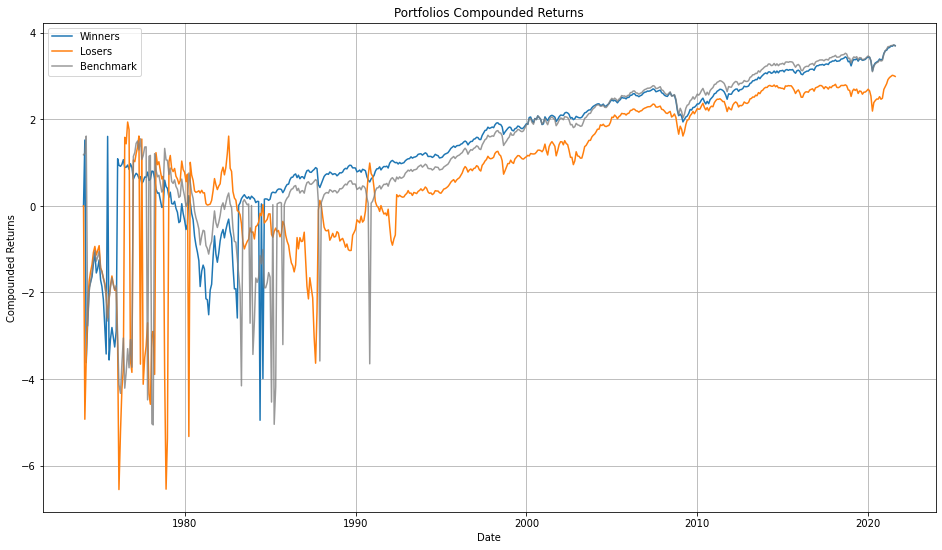

In [7]:
portfolios_ts = pqr.backtest_factor_portfolios(
    factor=mom,
    prices=prices,
    strategies=[
        pqr.utils.partial(pqr.time_series, min_threshold=0),
        pqr.utils.partial(pqr.time_series, max_threshold=0),
    ]
)

summary(portfolios_ts)

# Строим quantile факторную модель с 5 квантилями

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
"Monthly Mean Return, %",0.71*** (3.27),0.77*** (4.45),0.76*** (4.34),0.62*** (3.24),0.80*** (2.63)
"Monthly Volatility, %",5.19,4.13,4.21,4.56,7.24
"Maximum Drawdown, %",-51.77,-45.61,-47.09,-53.00,-55.24
Sharpe Ratio,0.47,0.65,0.63,0.47,0.38
"Mean Excess Return, %",-0.75,-0.04,-0.12,-1.86,0.27
"Alpha, %",-0.66 (-0.67),1.74*** (2.66),1.72** (2.12),-0.60 (-0.66),-2.36 (-1.25)
Beta,0.99,0.81,0.80,0.86,1.28


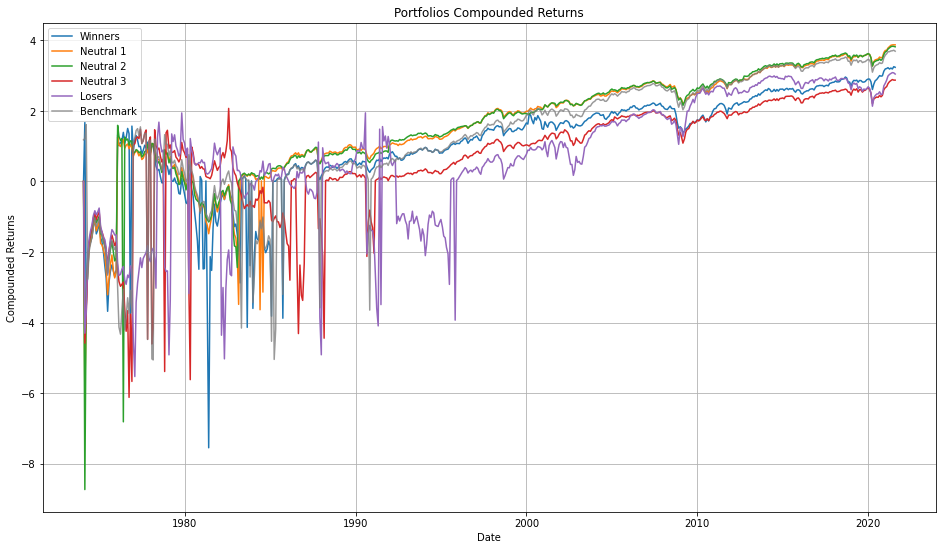

In [8]:
portfolios_q = pqr.backtest_factor_portfolios(
    factor=mom,
    prices=prices,
    strategies=list(reversed(pqr.split_quantiles(5))),
)
summary(portfolios_q)

# Пробуем OP-test

In [9]:
def upsample_portfolio(portfolio, period):
    return pqr.calculate_returns(
        prices=prices,
        holdings=portfolio.iloc[::period].drop(columns=["returns"]),
    )

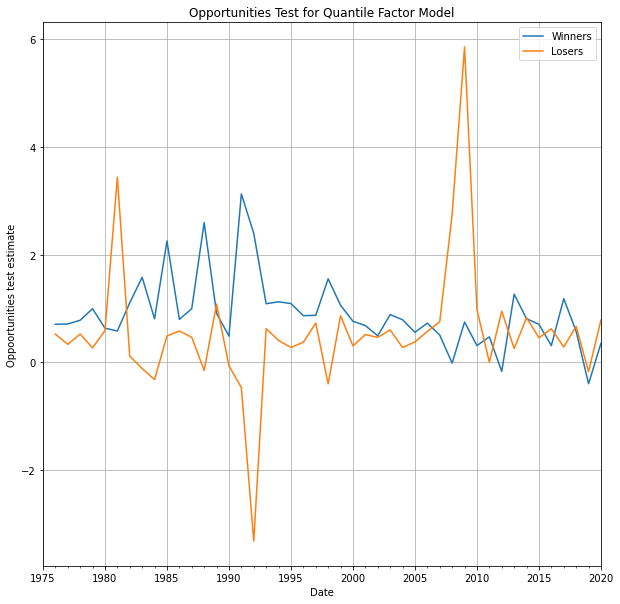

In [10]:
plt.figure(figsize=(10, 10))

wop = pqr.tests.opportunities_test(
    base_portfolio=upsample_portfolio(portfolios_ts[0], 12),
    prices=prices,
    universe=universe,
)
lop = pqr.tests.opportunities_test(
    base_portfolio=upsample_portfolio(portfolios_ts[-1], 12),
    prices=prices,
    universe=universe,
)

wop.plot(label=portfolios_ts[0].index.name)
lop.plot(label=portfolios_ts[-1].index.name)

plt.title("Opportunities Test for Quantile Factor Model")
plt.xlabel("Date")
plt.ylabel("Oppoortunities test estimate")
plt.legend()
plt.grid();

# Double time-series momentum

In [11]:
_, benchmark_returns = pqr.utils.align(mom, benchmark)
benchmark_returns = benchmark_returns.to_numpy()[:, np.newaxis]
double_ts_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.time_series(mom, min_threshold=0) & (benchmark_returns > 0),
    shorts=pqr.time_series(mom, max_threshold=0) & (benchmark_returns < 0),
    name="Double TS Momentum",
)

<AxesSubplot:xlabel='Double TS Momentum'>

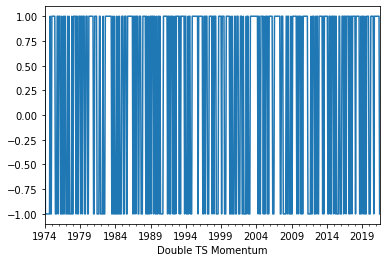

In [12]:
double_ts_portfolio.drop(columns=["returns"]).sum(axis=1).plot()

,Winners,Losers,Double TS Momentum
"Monthly Mean Return, %",0.75*** (4.12),0.69*** (2.92),0.83*** (3.77)
"Monthly Volatility, %",4.35,5.67,5.25
"Maximum Drawdown, %",-50.01,-47.67,-55.53
Sharpe Ratio,0.60,0.42,0.55
"Mean Excess Return, %",-0.27,-0.97,0.66
"Alpha, %",1.03 (1.65),-1.37 (-1.06),13.17*** (5.21)
Beta,0.86,1.04,-0.35


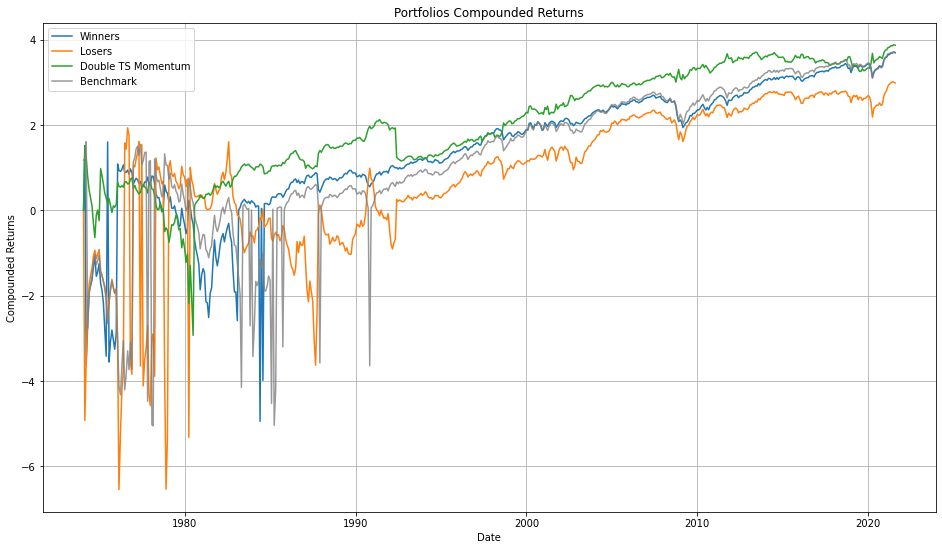

In [13]:
summary(portfolios_ts + [double_ts_portfolio])

Использование методики double time-series momentum действительно показало себя лучше простого моментума за счет тайминга, но есть подозрение, что с введением ограничения на шорты и комиссий, это уйдет, и получится либо такой же моментум, либо даже чуть хуже.